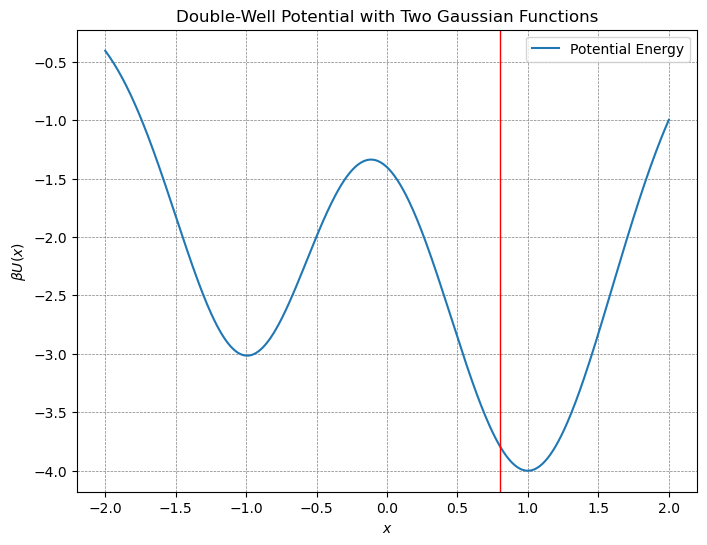

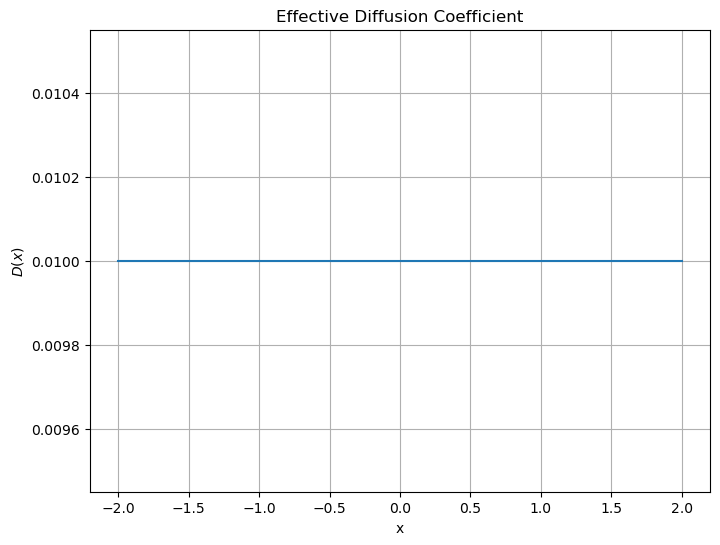

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator

# Define the double-well potential using two Gaussian functions
def double_gaussian_potential(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
beta_U = double_gaussian_potential

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0.8, color='red', linewidth=1)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, D(x))
plt.xlabel('x')
plt.ylabel("$D(x)$")
plt.title('Effective Diffusion Coefficient')
plt.grid(True)
plt.show()

In [2]:
a = -2.0   # location of reflecting boundary
b = 0.8   # location of absorbing boundary or upper reflecting boundary for equilibrium
recycle_loc = -1.2
h = 0.01
N = int((b-a)/h+1)
x_arr = np.linspace(a, b, N)

In [3]:
from transfer_matrix_reptile import TransferMatrix_ReInAb, TransferMatrix_ReRe
from transfer_matrix_recycle import TransferMatrix_Recycle

ria_trans = TransferMatrix_ReInAb(h, x_arr, beta_U, 0)
rr_trans = TransferMatrix_ReRe(h, x_arr, beta_U, 0)
rc_trans = TransferMatrix_Recycle(h, x_arr, beta_U, np.where(x_arr==recycle_loc), 0)

[1.        +0.j         0.99963059-0.00017818j 0.99963059+0.00017818j
 0.99891501-0.00038286j 0.99891501+0.00038286j 0.99768309-0.00056821j]
[1.        +0.j 0.99996762+0.j 0.99961642+0.j 0.99935705+0.j
 0.99892428+0.j 0.99837007+0.j]
[1.        +0.00000000e+00j 0.9996091 +0.00000000e+00j
 0.99935204+6.79086387e-05j 0.99935204-6.79086387e-05j
 0.99843663+0.00000000e+00j 0.99793086+0.00000000e+00j]


/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


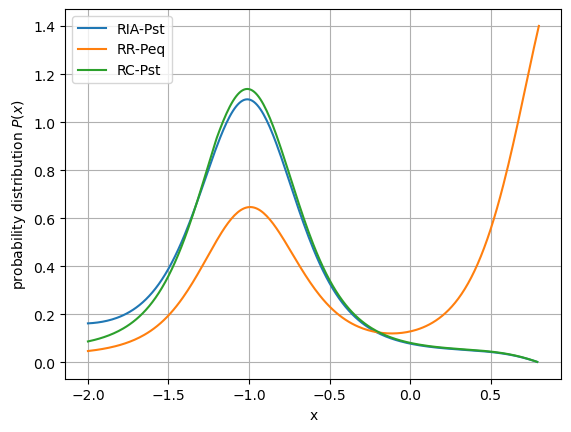

In [4]:
plt.plot(x_arr[:-1], ria_trans.steady_state, label="RIA-Pst")
plt.plot(x_arr, rr_trans.steady_state, label="RR-Peq")
plt.plot(x_arr[:-1], rc_trans.steady_state, label="RC-Pst")
plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()
print(ria_trans.eig6_w)
print(rr_trans.eig6_w)
print(rc_trans.eig6_w)

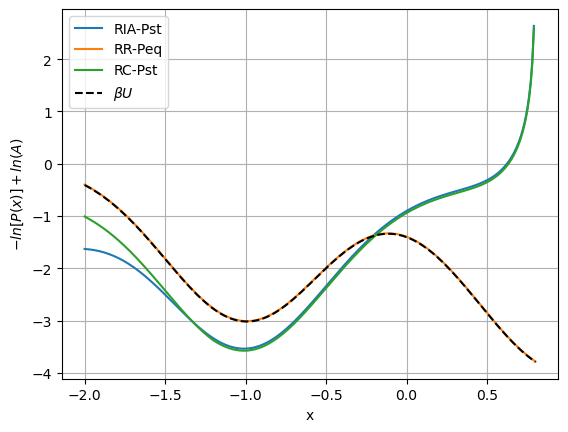

In [5]:
# partition function Q(A=1/Q) for equilibrium state 
def integrand(x):
    return np.exp(-beta_U(x))
Q, _ = quad(integrand, a, b)
A = 1/Q
plt.plot(x_arr[:-1], -np.log(ria_trans.steady_state)+np.log(A), label="RIA-Pst")
plt.plot(x_arr, -np.log(rr_trans.steady_state)+np.log(A), label="RR-Peq")
plt.plot(x_arr[:-1], -np.log(rc_trans.steady_state)+np.log(A), label="RC-Pst")
plt.plot(x_arr, beta_U(x_arr), '--k', label=r'$\beta U$')
plt.xlabel('x')
plt.ylabel("$-ln[P(x)]+ln(A)$")
plt.legend()
plt.grid()

In [6]:
from fluxIF_sampling_simulate import simulate_ReAb_count

num_particles = 400
init_position_arr = a*np.ones(num_particles, dtype=float)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+h, h)
n_arr = np.round(n_arr, decimals=5)
count_n = simulate_ReAb_count(init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx)

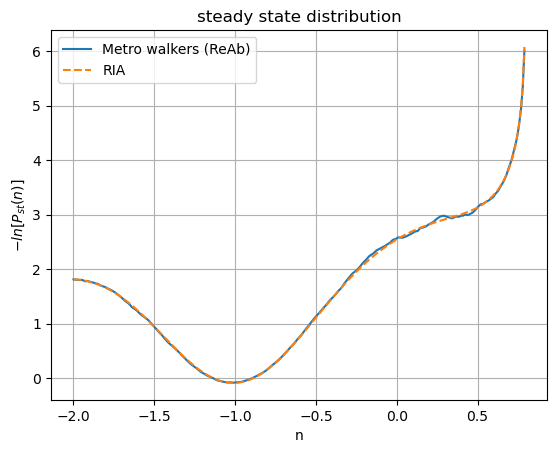

In [7]:
Pst_n = count_n/(h*np.sum(count_n))
plt.plot(n_arr[:-1], -np.log(Pst_n[:-1]), label="Metro walkers (ReAb)")
plt.plot(x_arr[:-1], -np.log(ria_trans.steady_state), '--', label="RIA")

# Plot formatting
plt.xlabel('n')
plt.ylabel("$-ln[P_{st}(n)]$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

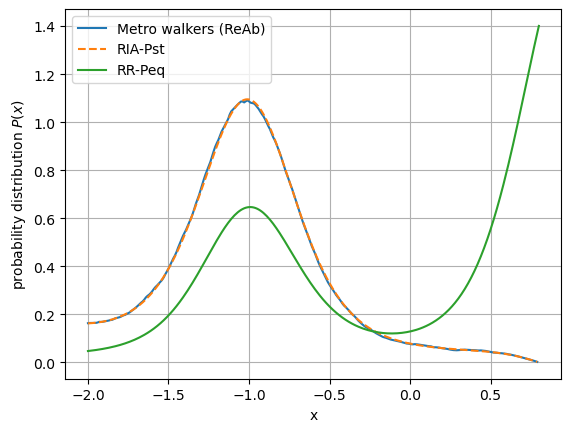

In [8]:
plt.plot(n_arr[:-1], Pst_n[:-1], label="Metro walkers (ReAb)")
plt.plot(x_arr[:-1], ria_trans.steady_state, '--', label="RIA-Pst")
plt.plot(x_arr, rr_trans.steady_state, label="RR-Peq")
plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()

In [9]:
# Initial injecting at x0=-1.2
num_particles = 400
init_position_arr = -1.2*np.ones(num_particles, dtype=float)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+h, h)
n_arr = np.round(n_arr, decimals=5)
count_n = simulate_ReAb_count(init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx)

/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


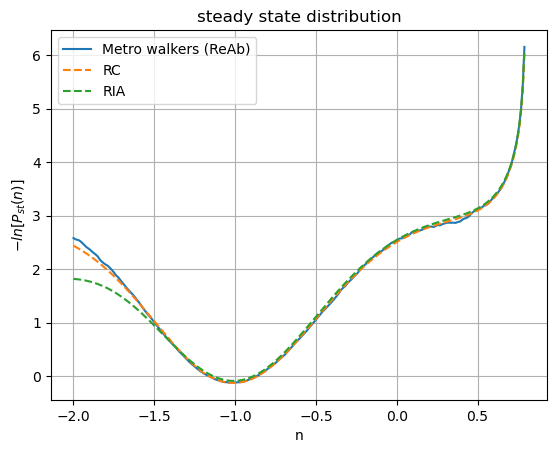

In [37]:
Pst_n = count_n/(h*np.sum(count_n))
plt.plot(n_arr[:-1], -np.log(Pst_n[:-1]), label="Metro walkers (ReAb)")
plt.plot(x_arr[:-1], -np.log(rc_trans.steady_state), '--', label="RC")
plt.plot(x_arr[:-1], -np.log(ria_trans.steady_state), '--', label="RIA")

# Plot formatting
plt.xlabel('n')
plt.ylabel("$-ln[P_{st}(n)]$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

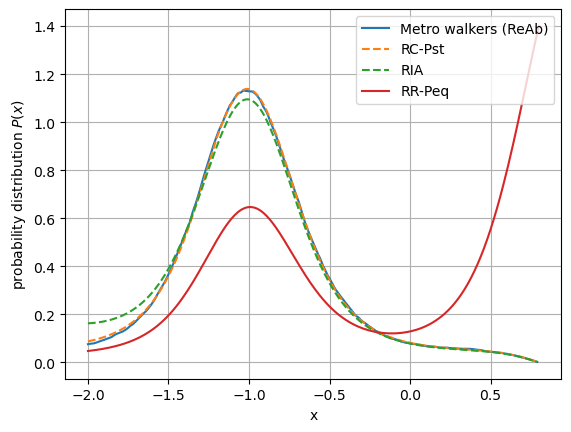

In [38]:
plt.plot(n_arr[:-1], Pst_n[:-1], label="Metro walkers (ReAb)")
plt.plot(x_arr[:-1], rc_trans.steady_state, '--', label="RC-Pst")
plt.plot(x_arr[:-1], ria_trans.steady_state, '--', label="RIA")
plt.plot(x_arr, rr_trans.steady_state, label="RR-Peq")
plt.xlabel('x')
plt.ylabel("probability distribution $P(x)$")
plt.legend()
plt.grid()

In [12]:
from fluxIF_sampling_simulate import simulate_ReAb_fluxIF

num_particles = 400
init_position_arr = a*np.ones(num_particles, dtype=float)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+h, h)
n_arr = np.round(n_arr, decimals=5)

/tmp/ipykernel_539554/1379965834.py:4: RuntimeWarning: divide by zero encountered in divide
  ratio_pi = flux_IF/flux_FI
/tmp/ipykernel_539554/1379965834.py:5: RuntimeWarning: invalid value encountered in multiply
  Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[0]/ria_trans.steady_state[0])*ria_trans.steady_state


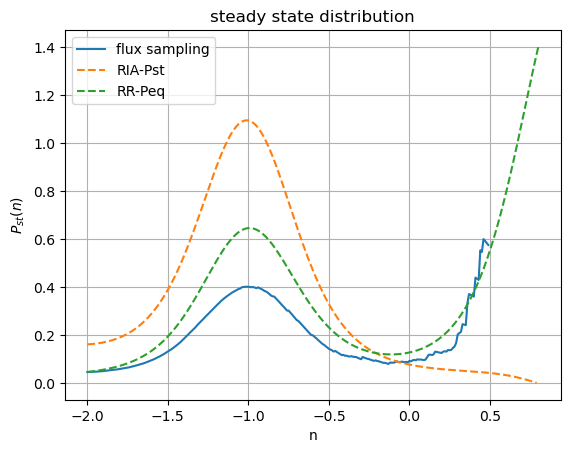

In [13]:
count_n, flux_IF, flux_FI = simulate_ReAb_fluxIF(
    init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx
    )
ratio_pi = flux_IF/flux_FI
Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[0]/ria_trans.steady_state[0])*ria_trans.steady_state
plt.plot(n_arr[:260], Peq_flux[:250], label="flux sampling")
plt.plot(x_arr[:-1], ria_trans.steady_state, '--', label="RIA-Pst")
plt.plot(x_arr, rr_trans.steady_state, '--', label="RR-Peq")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r"$P_{st}(n)$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

In [31]:
# x0=-1.2, a=-2
num_particles = 400
init_position_arr = -1.2*np.ones(num_particles, dtype=float)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+h, h)
n_arr = np.round(n_arr, decimals=5)
count_n, flux_IF, flux_FI = simulate_ReAb_fluxIF(
    init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=a, b=b, hx=hx
    )

In [32]:
np.where(x_arr == init_position_arr[0])

(array([80]),)

/tmp/ipykernel_539554/2266302651.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio_pi = flux_IF/flux_FI
/tmp/ipykernel_539554/2266302651.py:2: RuntimeWarning: invalid value encountered in multiply
  Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[80]/rc_trans.steady_state[80])*rc_trans.steady_state


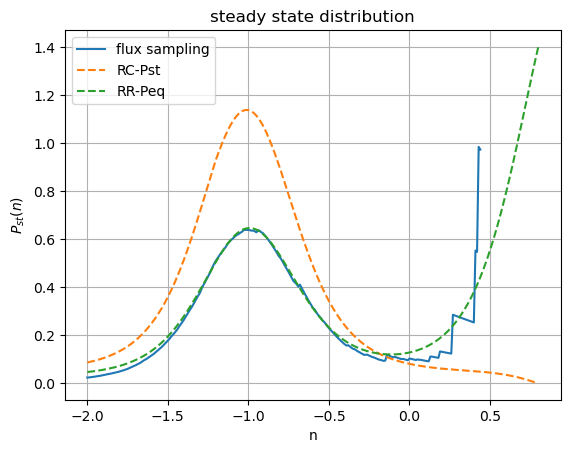

In [33]:
ratio_pi = flux_IF/flux_FI
Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[80]/rc_trans.steady_state[80])*rc_trans.steady_state
plt.plot(n_arr[:245], Peq_flux[:245], label="flux sampling")
plt.plot(x_arr[:-1], rc_trans.steady_state, '--', label="RC-Pst")
plt.plot(x_arr, rr_trans.steady_state, '--', label="RR-Peq")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r"$P_{st}(n)$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

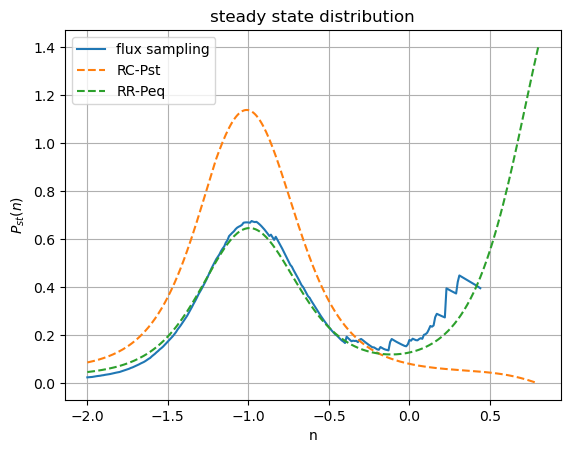

/tmp/ipykernel_539554/860586158.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio_pi = flux_IF/flux_FI
/tmp/ipykernel_539554/860586158.py:2: RuntimeWarning: invalid value encountered in multiply
  Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[80]/ria_trans.steady_state[80])*ria_trans.steady_state


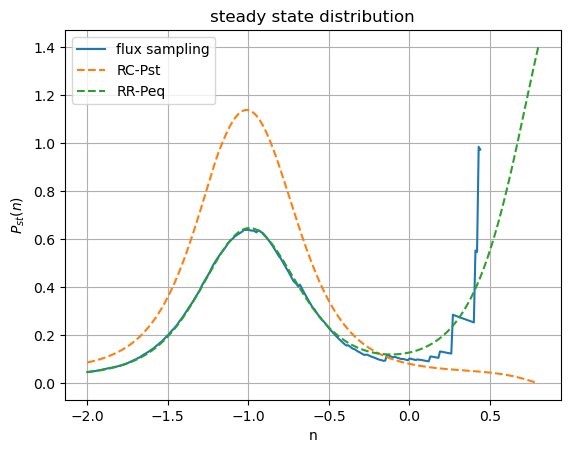

In [34]:
ratio_pi = flux_IF/flux_FI
Peq_flux = ratio_pi[:-1]*(rr_trans.steady_state[80]/ria_trans.steady_state[80])*ria_trans.steady_state
plt.plot(n_arr[:245], Peq_flux[:245], label="flux sampling")
plt.plot(x_arr[:-1], rc_trans.steady_state, '--', label="RC-Pst")
plt.plot(x_arr, rr_trans.steady_state, '--', label="RR-Peq")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r"$P_{st}(n)$")
plt.title('steady state distribution')
plt.legend()
plt.grid()

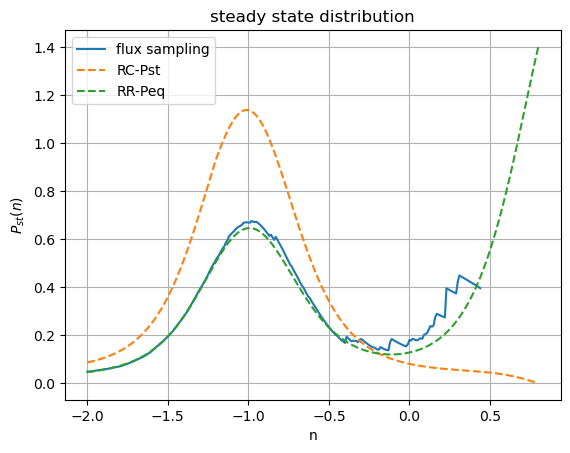

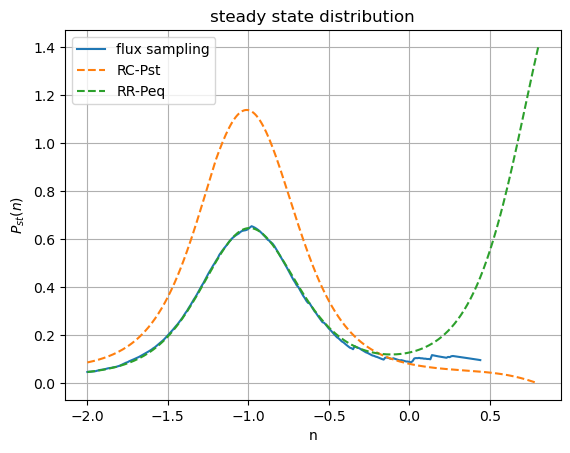

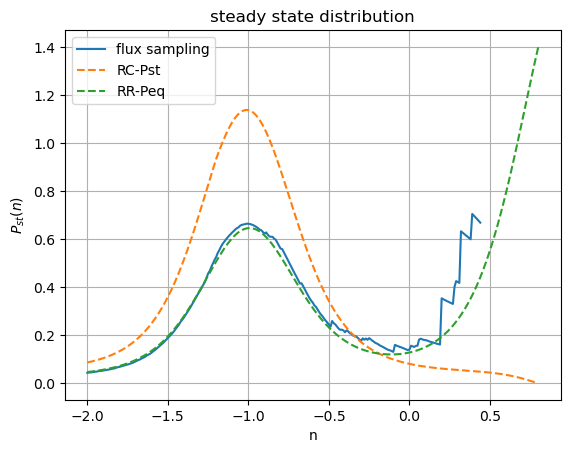

In [24]:
# x0=-1.2, a=-1.2
num_particles = 400
init_position_arr = -1.2*np.ones(num_particles)
hx = h
ht = hx**2/(2*D0)
n_arr = np.arange(-1.2, b+h, h)
n_arr = np.round(n_arr, decimals=5)
count_n, flux_IF, flux_FI = simulate_ReAb_fluxIF(
    init_position_arr=init_position_arr, beta_U=beta_U, n_arr=n_arr, a=-1.2, b=b, hx=hx
    )

In [26]:
ratio_pi = flux_IF/flux_FI
rr2_trans = TransferMatrix_ReRe(hx, n_arr, beta_U, criteria=0)
ria2_trans = TransferMatrix_ReInAb(hx, n_arr, beta_U, criteria=0)
print(ria2_trans.eig6_w)
print(rr2_trans.eig6_w)

[1.        +0.j         0.99937667-0.0001381j  0.99937667+0.0001381j
 0.99793875-0.00033215j 0.99793875+0.00033215j 0.99551607-0.00050516j]
[1.        +0.j 0.99996083+0.j 0.99942375+0.j 0.998823  +0.j
 0.9979853 +0.j 0.99690004+0.j]


/tmp/ipykernel_539554/1564597371.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio_pi = flux_IF/flux_FI


/tmp/ipykernel_539554/234394761.py:1: RuntimeWarning: invalid value encountered in multiply
  Peq_flux = ratio_pi[:-1]*(rr2_trans.steady_state[0]/ria2_trans.steady_state[0])*ria2_trans.steady_state


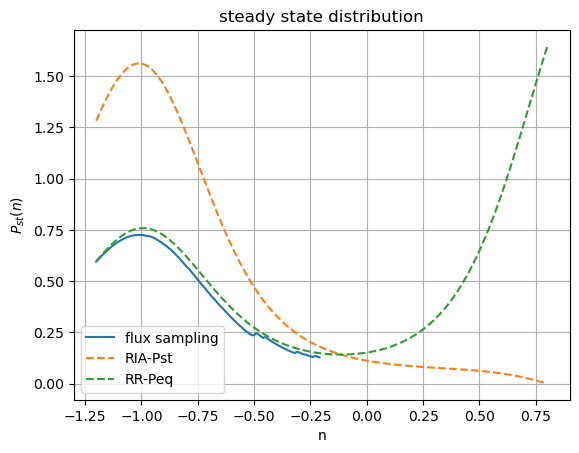

In [27]:
Peq_flux = ratio_pi[:-1]*(rr2_trans.steady_state[0]/ria2_trans.steady_state[0])*ria2_trans.steady_state
plt.plot(n_arr[:100], Peq_flux[:100], label="flux sampling")
plt.plot(n_arr[:-1], ria2_trans.steady_state, '--', label="RIA-Pst")
plt.plot(n_arr, rr2_trans.steady_state, '--', label="RR-Peq")

# Plot formatting
plt.xlabel('n')
plt.ylabel(r"$P_{st}(n)$")
plt.title('steady state distribution')
plt.legend()
plt.grid()
